# Project 3 - Face Morphing
Romil Bhardwaj

Before running this notebook, please annotate your faces using annotate.py

In [70]:
import csv
import numpy as np
import pandas as pd
import skimage.io as skio
import matplotlib.pyplot as plt
from matplotlib import animation
from numpy.linalg import LinAlgError
from scipy.spatial.qhull import Delaunay
from skimage.draw import draw
import os
import glob
import time

## Face Morphing Video

In [29]:
def get_affine_transform(tri1_pts, tri2_pts):
    m1 = np.array([tri1_pts[:,0], tri1_pts[:, 1], np.ones(3)])
    m2 = np.array([tri2_pts[:,0], tri2_pts[:, 1], np.ones(3)])
    return np.matmul(m2, np.linalg.inv(m1))

def masked_affine_tranform(im, mask, affine_transform):
    affine_0, affine_1, _ = np.matmul(np.linalg.inv(affine_transform), mask).astype(np.int)
    mask_0, mask_1, _ = mask.astype(np.int)
    result = np.zeros_like(im)
    result[mask_1, mask_0] = im[affine_1, affine_0]
    return result

def read_keypoints(csv_path):
    with open(csv_path, 'r') as f:
        return np.array([list(map(float,rec)) for rec in csv.reader(f, delimiter=',')])

def read_img_and_keypoints(img_path):
    img = skio.imread(img_path)
    
    img_filename = os.path.splitext(os.path.basename(img_path))[0]
    csv_path = os.path.join(os.path.dirname(img_path), f'{img_filename}.csv')
    
    keypoints = read_keypoints(csv_path)
    return img, keypoints

def get_triangle_mask(triangle, image_shape):
    points = draw.polygon(triangle[:,0], triangle[:,1], shape=(image_shape[1], image_shape[0], image_shape[2]))
    return np.vstack([points, np.ones(len(points[0]))])

def morph(im1, im2, pts1, pts2, triangles, warp_frac, dissolve_frac):
    avg_points = (dissolve_frac * pts1 + (1 - dissolve_frac) * pts2)
    result_img = np.zeros_like(im1, dtype=np.float)
    for t in triangles:
        mask = get_triangle_mask(avg_points[t], im1.shape)
        affine_tranform1 = get_affine_transform(pts1[t], avg_points[t])
        affine_tranform2 = get_affine_transform(pts2[t], avg_points[t])
        result_img += (warp_frac * masked_affine_tranform(im1, mask, affine_tranform1) + (1-warp_frac) * masked_affine_tranform(im2, mask, affine_tranform2)) / 255
    return result_img

def create_morph_vid(im1, im2, pts1, pts2, num_keyframes, out_path, loop_count=3):
    triangles = Delaunay(pts1).simplices
    warp_fracs = np.linspace(0,1,num_keyframes)
    dissolve_fracs = np.linspace(0,1,num_keyframes)
    frames = []
    fig = plt.figure()
    for warp_frac, dissolve_frac in zip(warp_fracs, dissolve_fracs):
        morphed_im = morph(im1, im2, pts1, pts2, triangles, warp_frac, dissolve_frac)
        mplframe = plt.imshow(morphed_im)
        plt.tight_layout()
        frames.append([mplframe])
    
    # Create reversed frames and loop loop_count times
    write_frames = (frames + list(reversed(frames)))*loop_count
    
    #fig.set_size_inches(int(im1.shape[1]/50), int(im1.shape[0]/50), 10)
    vid = animation.ArtistAnimation(fig, write_frames, interval=100000, repeat=False)
    vid.save(out_path, writer=animation.writers['ffmpeg'](fps=5))
    
    # Save midway face
    out_filename = os.path.splitext(os.path.basename(out_path))[0]
    midwayim_path = os.path.join(os.path.dirname(out_path), f'{out_filename}_midway.jpg')
    midway_img = morph(im1, im2, pts1, pts2, triangles, warp_frac=0.5, dissolve_frac=0.5)
    skio.imsave(midwayim_path, midway_img)
    

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


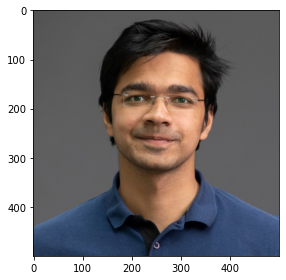

In [60]:
im1_path = 'imgs/jamesmay.jpg'
im2_path = 'imgs/romil.jpg'
im1, pts1 = read_img_and_keypoints(im1_path)
im2, pts2 = read_img_and_keypoints(im2_path)
create_morph_vid(im1, im2, pts1, pts2, 10, 'out.mp4')

## Mean Face of a population


In [96]:
def masked_affine_tranform(im, mask, affine_transform):
    affine_0, affine_1, _ = np.matmul(np.linalg.inv(affine_transform), mask).astype(np.int)
    mask_0, mask_1, _ = mask.astype(np.int)
    result = np.zeros_like(im)
    result[mask_1, mask_0] = im[affine_1, affine_0] # test
    return result

def get_mean_face(imgs, pts):
    triangles = Delaunay(pts[0]).simplices
    mean_pts = np.array(kps).mean(axis=0)
    morphed_imgs = []
    mean_img = np.zeros_like(imgs[0]).astype(np.float)
    for t in triangles:
        target_triangle = mean_pts[t]
        target_mask = get_triangle_mask(target_triangle, imgs[0].shape)
        for im, pt in zip(imgs, pts):
            affine_tranform1 = get_affine_transform(pt[t], mean_pts[t])
            try:
                morphed_img = (masked_affine_tranform(im, target_mask, affine_tranform1)/255)
                morphed_imgs.append(morphed_img)
                mean_img += morphed_img/len(imgs)
            except LinAlgError:
                continue
            except IndexError:  # Badly sized images
                continue
    return mean_img, mean_pts, morphed_imgs

def read_danes_dataset(dataset_root):
    # Get list of jpgs, return imgs and keypoints
    imgs, keypoints = [], []
    for img_path in glob.glob(dataset_root + '*.jpg'):
        img, keypoints_absolute = read_danes_img_and_keypoints(img_path)
        assert img.shape == (480, 640, 3)
        imgs.append(img)
        keypoints.append(keypoints_absolute)
    return imgs, keypoints

def read_danes_img_and_keypoints(img_path):
    img = skio.imread(img_path)
    
    img_filename = os.path.splitext(os.path.basename(img_path))[0]
    asf_path = os.path.join(os.path.dirname(img_path), f'{img_filename}.asf')
    df = pd.read_csv(asf_path, header=None, skiprows=16, nrows=58, delimiter='\t')
    image_corners = pd.DataFrame([[0,0],[0,1],[1,0],[1,1]], columns=[2,3])
    df = df.append(image_corners, ignore_index=True)
    keypoints_relative = df[[2,3]]
    keypoints_absolute = keypoints_relative.copy()
    keypoints_absolute[2] = keypoints_absolute[2]*img.shape[1]
    keypoints_absolute[3] = keypoints_absolute[3]*img.shape[0]
    keypoints_absolute = np.array(keypoints_absolute)
    
    return img, keypoints_absolute

# Subset of keypoints used for transforming my face. Ordering is important here.
# Left jaw, chin, right jaw, left mouth, right mouth, nose bottom center, left eye, right eye + corners
KPS_SUBSET = [0, 6, 12, 39, 43, 52, 23, 15] + [58, 59, 60, 61]

#### Test dataset reading

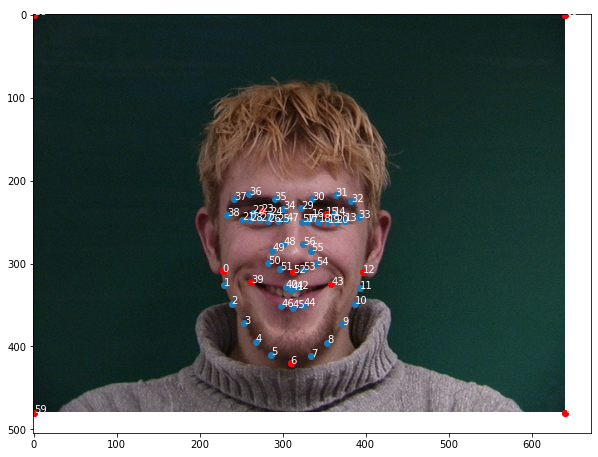

In [98]:
# Test dataset reading
img, kp = read_danes_img_and_keypoints('imm_face/01-2m.jpg')
plt.figure(figsize=[10,10])
plt.imshow(img)
plt.scatter(x=kp[:,0], y=kp[:,1])
plt.scatter(x=kp[KPS_SUBSET,0], y=kp[KPS_SUBSET,1], color='red')
for i, p in enumerate(kp):
    plt.text(p[0], p[1], i, color='white')

## Mean face of the dataset

In [ ]:
dataset_root = 'imm_face/'
imgs, kps = read_danes_dataset(dataset_root)
mean_img, mean_pts, morphed_imgs = get_mean_face(imgs, kps)

In [ ]:
plt.imshow(mean_img)
plt.title('Mean face of the Danes Dataset')
plt.savefig('mean_face.jpg', bbox_inches='tight')